In [1]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast

In [2]:
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
CKPT_PATH = '../input/yolov5s6/sub2_ep15best.pt'
IMG_SIZE  = 3584  # 
CONF      = 0.3     # 1920*3 + conf-0.3
IOU       = 0.5
AUGMENT   = True     # TTA will run for an hour, will gain improvement
TRACKING  = True
FDA_aug   = False

# Tracker

In [3]:
if TRACKING:
    # Dependencies
    %cd /kaggle/input/norfair031py3/
    !pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
    !pip install rich-9.13.0-py3-none-any.whl

    !mkdir /kaggle/working/tmp
    !cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
    %cd /kaggle/working/tmp/filterpy-1.4.5/
    !pip install .
    !rm -rf /kaggle/working/tmp

    %cd /kaggle/input/norfair031py3/
    !pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index
    %cd /kaggle/working/

    from norfair import Detection, Tracker

    def to_norfair(detects, frame_id):
        result = []
        for x_min, y_min, x_max, y_max, score in detects:
            xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
            w, h = x_max - x_min, y_max - y_min
            result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))

        return result

    # Euclidean distance function to match detections on this frame with tracked_objects from previous frames
    def euclidean_distance(detection, tracked_object):
        return np.linalg.norm(detection.points - tracked_object.estimate)

    tracker = Tracker(
        distance_function=euclidean_distance, 
        distance_threshold=30,
        hit_inertia_min=3,
        hit_inertia_max=6,
        initialization_delay=1,
    )
    frame_id = 0


/kaggle/input/norfair031py3
Looking in links: ./
Processing ./commonmark-0.9.1-py2.py3-none-any.whl
Processing ./rich-9.13.0-py3-none-any.whl
/kaggle/working/tmp/filterpy-1.4.5
Processing /kaggle/working/tmp/filterpy-1.4.5
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=3244ae2e907a2bb8efbee162b2c1d9dfbedb4ea1cc54d7854950ad577fac39b2
  Stored in directory: /root/.cache/pip/wheels/0e/ba/6d/20557ee403bc0c849d9fe3b358ded9918d7d2b0c5b0253fc99
Successfully built filterpy
/kaggle/input/norfair031py3
Looking in links: ./
Processing ./norfair-0.3.1-py3-none-any.wh

In [4]:
def get_path(row):
    row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [5]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df = df.progress_apply(get_path, axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,0,0,0-0,[],/kaggle/input/tensorflow-great-barrier-reef//t...
1,0,40258,1,1,0-1,[],/kaggle/input/tensorflow-great-barrier-reef//t...


## Number of BBoxes

In [6]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


# 🔨 Helper

In [7]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
# from bbox.utils import coco2yolo, coco2voc, voc2yolo
# from bbox.utils import draw_bboxes, load_image
# from bbox.utils import clip_bbox, str2annot, annot2str

# def get_bbox(annots):
#     bboxes = [list(annot.values()) for annot in annots]
#     return bboxes

# def get_imgsize(row):
#     row['width'], row['height'] = imagesize.get(row['image_path'])
#     return row

# np.random.seed(32)
# colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
#           for idx in range(1)]

In [8]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [9]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [10]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('../input/d/awsaf49/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou   # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

# 🔭 Inference

## Helper

In [11]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [12]:
def tracking_function(tracker, frame_id, bboxes, scores):
    
    detects = []
    predictions = []
    
    if len(scores)>0:
        for i in range(len(bboxes)):
            box = bboxes[i]
            score = scores[i]
            x_min = int(box[0])
            y_min = int(box[1])
            bbox_width = int(box[2])
            bbox_height = int(box[3])
            detects.append([x_min, y_min, x_min+bbox_width, y_min+bbox_height, score])
            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
#             print(predictions[:-1])
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        
    return predictions

In [13]:
def extract_bbox(anno):
    for idx, a in enumerate(anno):
        try:
            anno[idx] = [a['x'], a['y'], a['width'], a['height']]
        except:
            break
    return anno

## Run Inference on **Train**

In [14]:
!cp ../input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [15]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

YOLOv5 🚀 2022-2-5 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


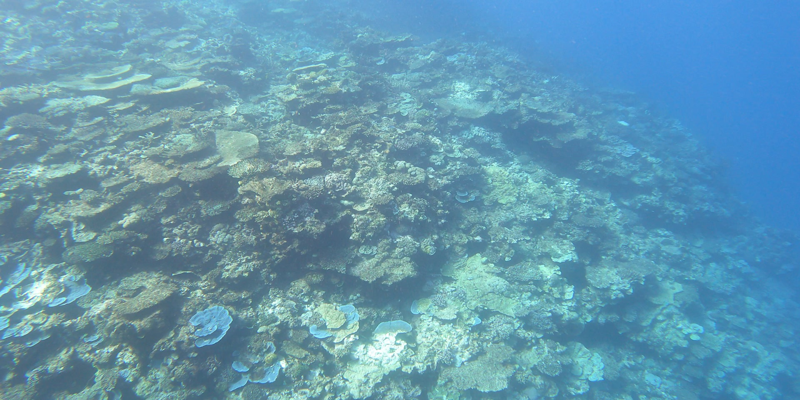

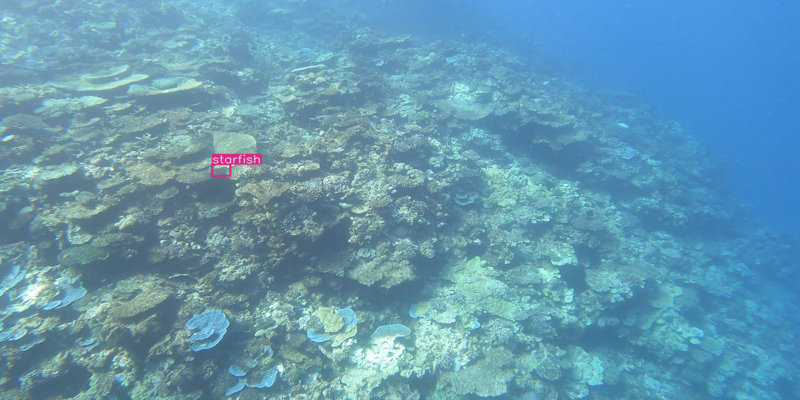

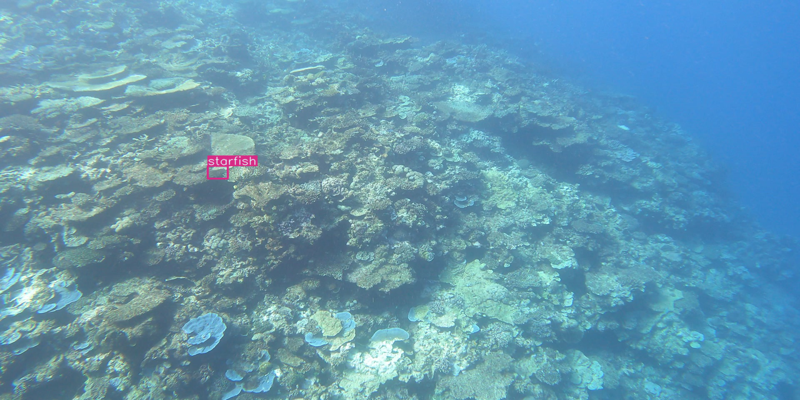

In [16]:
if TRACKING:
    tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

    model = load_model(CKPT_PATH, conf=CONF, iou=IOU)

    frame_id =0
    for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
        if FDA_aug:
            img = FDA_trans(image=img)['image']
        bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=AUGMENT)

        predictions = tracking_function(tracker, frame_id, bboxes, confs)

        prediction_str = ' '.join(predictions)
        pred_df['annotations'] = prediction_str
        env.predict(pred_df)
        if frame_id < 3:
            if len(predictions)>0:
                box = [list(map(int,box.split(' ')[1:])) for box in predictions]
            else:
                box = []
            display(show_img(img, box, bbox_format='coco'))
    #     print('Prediction:', pred_df)
        frame_id += 1

else:
    model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
    for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
        bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
        annot          = format_prediction(bboxes, confs)
        pred_df['annotations'] = annot
        env.predict(pred_df)
        if idx<3:
            display(show_img(img, bboxes, bbox_format='coco'))
    

# 👀 Check Submission

In [17]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

,index,annotations
0,0,NaN
1,1,0.33 339 295 29 21
2,2,0.36 332 298 32 23
